Deedsで変形するために色々データを眺める。  
正常ガンに投影するためには、どの患者の左右どちらに正常ガンがあるかを調べる必要がある。  

また、各ユーザに対するスペーシング幅やOriginも揃える必要がある。  

In [1]:
import SimpleITK as sitk
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', 100)
from pyobb.obb import OBB

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
statistics_path='/home/kakeya/Desktop/higuchi/20191021/output/statistics.csv'
st_df=pd.read_csv(statistics_path,index_col=0)
cols=['count','count_CCR','count_cys','lumi_mean']
mini_df=st_df[cols].reset_index().fillna(0)
mini_df.head()

,index,count,count_CCR,count_cys,lumi_mean
0,1,369526,0.0,4787.0,166.598161
1,2,336744,8872.0,4181.0,187.855472
2,3,297822,1092.0,0.0,150.493379
3,4,308553,31025.0,3197.0,98.561761
4,5,395548,1847.0,955.0,112.893234


In [4]:
#mini_ccr_df=mini_df.query('0<count_CCR<10000')
mini_ccr_df=mini_df.query('0<count_CCR')

In [5]:
ccr_cids=mini_ccr_df['index'].values

In [6]:
## linearBCV -F /home/kakeya/Desktop/higuchi/data/00127/SE2.nii.gz -M /home/kakeya/Desktop/higuchi/data/00015/SE2.nii.gz -O ./affine

In [7]:
#deedsBCV -F /home/kakeya/Desktop/higuchi/data/00127/SE2.nii.gz -M /home/kakeya/Desktop/higuchi/data/00015/SE2.nii.gz -O ./BCVs -A ./affine_matrix.txt

In [16]:
cid=2

In [54]:
cid=3
path=f'/home/kakeya/Desktop/higuchi/data/{str(cid).zfill(5)}/CCRCC.nii.gz'
ccrcc_arr=sitk.GetArrayFromImage(sitk.ReadImage(path))
image=sitk.ReadImage(path)

In [55]:
ccrcc.GetSize()

(512, 512, 121)

In [62]:
ccrcc.GetSpacing()

(0.7429999709129333, 0.7429999709129333, 2.0)

In [57]:
scaled_size = [round(s * 1.2) for s in image.GetSize()]

# パラメータの設定
#  scaleTransform = sitk.ScaleTransform(3, [scale_rate] * 3)
#  scaleTransform.SetCenter(np.array(image.GetSize())/2)
scaled_size

[614, 614, 175]

In [59]:
affinTransform = sitk.AffineTransform(3)
affinTransform.Scale([1/1.2] * 3)

In [61]:
def resample_isocubic(img, new_spacing):
    def calc_new_size():
        np_size = np.array(img.GetSize())
        np_cur_spacing = np.array(img.GetSpacing())
        np_new_spacing = np.array(new_spacing)
        
        np_new_size = np_size * np_cur_spacing / new_spacing
        return np_new_size.astype(int).tolist()
        
    origin = img.GetOrigin()
    size = img.GetSize()
    cur_spacing = img.GetSpacing()
    direction = img.GetDirection()
    
    new_size = calc_new_size()
    print(new_size)
    transform = sitk.Transform()                # default is 'IdentityTransform'
    interpolator = sitk.sitkNearestNeighbor
    
    return sitk.Resample(img, 
                         new_size,
                         transform,
                         interpolator,
                         origin,
                         new_spacing,
                         direction,
                         0.0,
                         img.GetPixelIDValue())

In [69]:
def resampleMask_isocubic(img, base_spacing, ref_img):
    img.SetSpacing(base_spacing)                # change with the same spacing of reference
    transform = sitk.Transform()                # default is 'IdentityTransform'
    interpolator = sitk.sitkNearestNeighbor
    
    return sitk.Resample(img, 
                         ref_img.GetSize(),
                         transform,
                         interpolator,
                         ref_img.GetOrigin(),
                         ref_img.GetSpacing(),
                         ref_img.GetDirection(),
                         0.0,
                         img.GetPixelIDValue())


In [64]:
new_spacing=(0.7,0.7,2)
resample_ccr=resample_isocubic(ccrcc,new_spacing)

[543, 543, 121]


In [72]:
@staticmethod
def CropCenter(img: np.array, croped_size=512):
    """
    zyxに並んでいる必要がある。
    Spacing幅を変えたときにxyをcrop
    """
    if img.shape[1]<padded_size:
        raise ValueError('this img is lager than croped_size')
    if img.shape[0] == img.shape[1]:
        raise ValueError('this img is not square.')
    _, y, x = img.shape
    startx = x // 2 - (croped_size // 2)
    return img[:, startx:startx + croped_size, startx:startx + croped_size]

@staticmethod
def PadCenter(img: np.array, padded_size=512):
    """
    zyxに並んでいる必要がある。
    Spacing幅を変えたときにxyをpadding
    """
    if img.shape[1]>padded_size:
        raise ValueError('this img is lager than padded_size')
    if img.shape[1] != img.shape[2]:
        raise ValueError('this img is not square.')

    pad_size = padded_size - img.shape[1]
    rpad = pad_size // 2
    lpad = int(np.ceil(pad_size / 2))
    return np.pad(img, ((0, 0),(rpad, lpad), (rpad, lpad)), 'minimum')

def resample_isocubic(img, new_spacing):
    def calc_new_size():
        np_size = np.array(img.GetSize())
        np_cur_spacing = np.array(img.GetSpacing())
        np_new_spacing = np.array(new_spacing)
        
        np_new_size = np_size * np_cur_spacing / new_spacing
        return np_new_size.astype(int).tolist()
        
    origin = img.GetOrigin()
    size = img.GetSize()
    cur_spacing = img.GetSpacing()
    direction = img.GetDirection()
    
    new_size = calc_new_size()
    print(new_size)
    transform = sitk.Transform()                # default is 'IdentityTransform'
    interpolator = sitk.sitkNearestNeighbor
    
    return sitk.Resample(img, 
                         new_size,
                         transform,
                         interpolator,
                         origin,
                         new_spacing,
                         direction,
                         0.0,
                         img.GetPixelIDValue())
def resampleMask_isocubic(img, base_spacing, ref_img):
    img.SetSpacing(base_spacing)                # change with the same spacing of reference
    transform = sitk.Transform()                # default is 'IdentityTransform'
    interpolator = sitk.sitkNearestNeighbor
    
    return sitk.Resample(img, 
                         ref_img.GetSize(),
                         transform,
                         interpolator,
                         ref_img.GetOrigin(),
                         ref_img.GetSpacing(),
                         ref_img.GetDirection(),
                         0.0,
                         img.GetPixelIDValue())
# mha_file = "../chd_sample/001_dia_M.mha"

def profile_image(image:sitk):
    spacing=image.GetSpacing()
    direction=image.GetDirection()    
    size=image.GetSize()    
    print(">> spacing={}  , direction={}, size={}".format(spacing, direction, size))
    
mha_file  =f'/home/kakeya/Desktop/higuchi/data/{str(cid).zfill(5)}/SE2.nii.gz'
mask_mha_file =f'/home/kakeya/Desktop/higuchi/data/{str(cid).zfill(5)}/CCRCC.nii.gz'

image = sitk.ReadImage(mha_file)
maskimage = sitk.ReadImage(mask_mha_file)
profile_image(image)
new_spacing = (0.7, 0.7, 2)

resampled_image = resample_isocubic(image, new_spacing)
profile_image(resampled_image)

resampled_mask_image = resampleMask_isocubic(maskimage, raw_spacing, resampled_image)
profile_image(resampled_mask_image)


spacing=(0.78125, 0.78125, 2.0)  , direction=(1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, -1.0), size=(512, 512, 146)
[571, 571, 146]
after resampling >> spacing=(0.7, 0.7, 2.0)  , direction=(1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, -1.0), size=(571, 571, 146)
after resampling mask image >> spacing=(0.7, 0.7, 2.0)  , direction=(1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, -1.0), size=(571, 571, 146)


In [20]:
# for cid in range(1,150):
#     path=f'/home/kakeya/Desktop/higuchi/data/{str(cid).zfill(5)}/CCRCC.nii.gz'
#     try:
#         ccrcc_arr=sitk.GetArrayFromImage(sitk.ReadImage(path))
#         ccrcc=sitk.ReadImage(path)
#         print(cid,end=',')
#         if (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, -1.0)!=ccrcc.GetDirection():
#             print(ccrcc.GetDirection())
#     except:
#         print('pass')

pass
2,3,4,5,6,pass
8,9,10,11,12,13,14,15,16,17,18,19,pass
21,22,pass
pass
25,pass
pass
28,29,30,31,32,33,34,pass
pass
37,38,39,40,41,pass
pass
44,45,46,47,pass
pass
pass
51,pass
53,pass
55,pass
57,58,pass
60,61,62,63,64,65,66,67,68,69,pass
71,72,73,74,pass
76,77,78,79,pass
pass
82,83,pass
pass
86,pass
88,pass
90,pass
pass
93,94,95,96,97,98,pass
pass
101,102,103,104,105,pass
107,pass
109,pass
pass
112,113,pass
115,pass
117,118,119,pass
121,122,123,124,125,126,127,pass
pass
130,pass
pass
pass
134,135,136,pass
138,pass
140,pass
142,pass
pass
145,146,147,pass
149,

In [149]:
mini_ccr_df['right']=0
mini_ccr_df['left']=0
mini_ccr_df['slices']=0
mini_ccr_df['spacing_xy']=0.0
mini_ccr_df['spacing_z']=0.0
for i in range(3):
    mini_ccr_df[f'origin_{i}']=0.0


mini_ccr_df.reset_index(drop=True,inplace=True)
for i,cid in enumerate(cids):
    path=f'/home/kakeya/Desktop/higuchi/data/{str(cid).zfill(5)}/SE2.nii.gz'cc
    raw_ccrcc=sitk.ReadImage(path)
    raw_ccrcc.SetSpacing((0.7,0.7,2.0))
    ccrcc=sitk.GetArrayFromImage(raw_ccrcc)
    if raw_ccrcc.GetSpacing()[0]!=raw_ccrcc.GetSpacing()[1]:
        raise ValueError('x spacing and y one are not same.')
    mini_ccr_df.at[i,'spacing_xy']=raw_ccrcc.GetSpacing()[0]
    mini_ccr_df.at[i,'spacing_z']=raw_ccrcc.GetSpacing()[2]
    for j in range(3):
        mini_ccr_df.at[i,f'origin_{j}']=raw_ccrcc.GetOrigin()[j]
    
    right=ccrcc[:,:,256:]
    left=ccrcc[:,:,:256]
    mini_ccr_df.at[i,'slices']=ccrcc.shape[0]
    mini_ccr_df.at[i,'right']=1 if right.sum()>0 else 0
    mini_ccr_df.at[i,'left']=1 if left.sum()>0 else 0    

In [153]:
mini_ccr_df.sort_values('slices').head(20)

,index,count,count_CCR,count_cys,lumi_mean,right,left,slices,spacing_xy,spacing_z,origin,size,origin_0,origin_1,origin_2
88,126,581488,6639.0,0.0,129.052146,0,0,71,0.7,2.0,-134.1_-118.5_1582.5,,-134.102005,-118.476997,1582.500000
95,140,609010,10260.0,0.0,144.732817,0,0,73,0.7,2.0,-87.2_-124.0_1630.5,,-87.246696,-123.964996,1630.500000
30,40,503748,119081.0,236.0,77.606960,0,0,82,0.7,2.0,-174.7_-319.7_-266.9,,-174.658005,-319.657990,-266.899994
101,150,690376,4979.0,0.0,148.489942,0,0,85,0.7,2.0,-146.6_-141.9_1534.0,,-146.582001,-141.895004,1534.000000
46,65,406813,24064.0,24628.0,105.880599,0,0,87,0.7,2.0,-164.7_-279.7_1250.1,,-164.688004,-279.687988,1250.099976
7,10,523632,8602.0,73798.0,113.629730,0,0,91,0.7,2.0,-182.1_-49.6_80.0,,-182.052994,-49.631599,80.000000
11,14,449899,8859.0,69930.0,79.036582,0,0,91,0.7,2.0,-200.0_-75.0_-10.0,,-200.000000,-75.000000,-10.000000
35,47,547062,177968.0,58689.0,89.556973,0,0,93,0.7,2.0,-185.6_-319.6_-346.7,,-185.647995,-319.648010,-346.700012
84,122,679953,7791.0,214.0,133.123704,0,0,93,0.7,2.0,-137.2_-100.5_1685.0,,-137.227005,-100.508003,1685.000000
50,69,382154,4125.0,35.0,179.086175,0,0,95,0.7,2.0,-177.0_-25.0_503.8,,-177.000000,-25.000000,503.799988


In [154]:
mini_ccr_df.sort_values('slices').tail(20)

,index,count,count_CCR,count_cys,lumi_mean,right,left,slices,spacing_xy,spacing_z,origin,size,origin_0,origin_1,origin_2
77,112,457739,44579.0,0.0,127.505528,0,0,151,0.7,2.0,-194.9_-89.4_-30.0,,-194.940002,-89.400002,-30.000000
102,151,431353,35706.0,55320.0,80.827438,0,0,151,0.7,2.0,-199.8_-186.2_1776.5,,-199.830994,-186.158997,1776.500000
91,134,441912,46960.0,0.0,146.642447,0,0,152,0.7,2.0,-175.0_-23.0_624.2,,-175.000000,-23.000000,624.200012
3,5,395548,1847.0,955.0,112.893234,0,0,153,0.7,2.0,-195.0_-61.0_-15.0,,-195.000000,-61.000000,-15.000000
34,46,425192,48616.0,0.0,124.846726,0,0,155,0.7,2.0,-181.6_-326.6_-345.3,,-181.647995,-326.648010,-345.299988
31,41,457291,91198.0,0.0,74.784043,0,0,163,0.7,2.0,-187.6_-325.6_-358.9,,-187.628998,-325.628998,-358.899994
26,34,1039880,247135.0,0.0,90.690433,0,0,163,0.7,2.0,-185.6_-305.6_-298.6,,-185.647995,-305.648010,-298.600006
36,51,387969,73960.0,0.0,128.587913,0,0,172,0.7,2.0,-189.6_-316.6_-419.5,,-189.639008,-316.639008,-419.500000
99,147,316556,53594.0,163.0,135.747451,0,0,176,0.7,2.0,-247.6_-246.6_1948.5,,-247.563995,-246.587997,1948.500000
70,101,282613,61172.0,14593.0,112.206526,0,0,202,0.7,2.0,-170.0_-19.0_586.6,,-170.000000,-19.000000,586.599976


## size of ccrcc

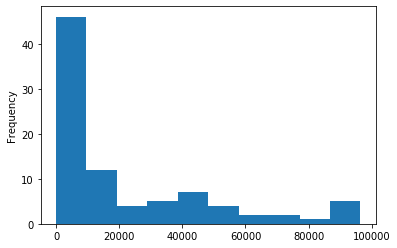

In [15]:
mini_df[mini_df['count_CCR']<100000]['count_CCR'].plot.hist(bins=10)

### lumi_mean

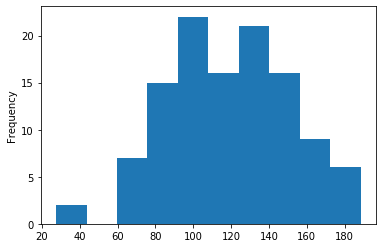

In [10]:
mini_df.sort_values('lumi_mean')['lumi_mean'].plot.hist()

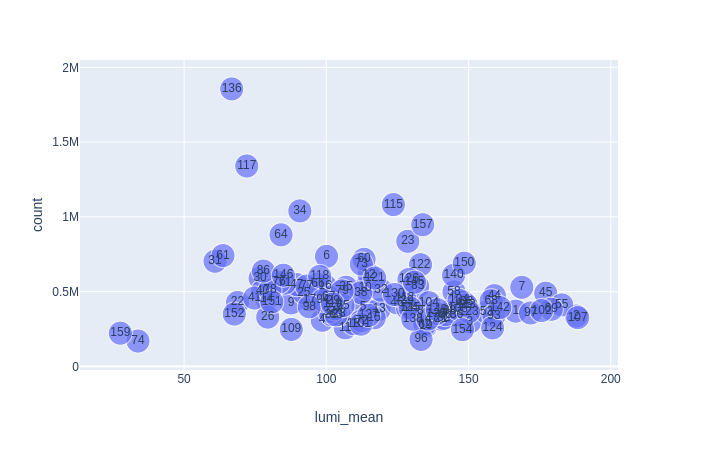

In [24]:
import plotly.express as px 
mini_df['size']=10
fig=px.scatter(mini_df,x='lumi_mean',y='count',text='index',size='size',size_max=17)
fig.show()

In [10]:
import numpy as np
from pathlib import Path
import SimpleITK as sitk
import pandas as pd


class DeedsPreprocessor(object):
    '''
    Deedsを使うときの前処理を行うクラス。
    - スペーシング幅を調整したあとに解像度をpadding/cropで調整する。
    - マスクがある場所の周辺のみをスライスに使用する。どのスライスを採用するかは、DataFrameに保存する
    - ↑の調整をしたデータを新たにディレクトリを作って保存する。
    '''

    def __init__(self, data_dir, save_dir, st_path,start_id=0, kidney='kidney.nii.gz',
                 ccrcc='CCRCC.nii.gz', cyst='cyst.nii.gz', SEs=['SE2.nii.gz', 'SE3.nii.gz']):
        self.data_dir = data_dir
        self.save_dir = save_dir
        self.kidney = kidney
        self.ccrcc = ccrcc
        self.cyst = cyst
        self.SEs = SEs
        self.st_df = pd.read_csv(st_path)
        self.start_id=start_id
        self.spacing = (0.7, 0.7, 2.0)
        self.df_path = './deeds_statistics.csv'
        cols = ['index','count', 'count_CCR', 'count_cys', 'lumi_mean']
        # statistics_dfから必要なデータだけを抽出する。
        self.mini_df = self.st_df[cols].reset_index().fillna(0)
        display(self.mini_df.head())

    @staticmethod
    def CropCenter(img: np.array, croped_size=512):
        """
        zyxに並んでいる必要がある。
        Spacing幅を変えたときにxyをcrop
        """
        if img.shape[1] < croped_size:
            raise ValueError('this img is lager than croped_size')
        if img.shape[0] == img.shape[1]:
            raise ValueError('this img is not square.')
        _, y, x = img.shape
        startx = x // 2 - (croped_size // 2)
        return img[:, startx:startx + croped_size, startx:startx + croped_size]

    @staticmethod
    def PadCenter(img: np.array, padded_size=512):
        """
        zyxに並んでいる必要がある。
        Spacing幅を変えたときにxyをpadding
        """
        if img.shape[1] > padded_size:
            raise ValueError('this img is lager than padded_size')
        if img.shape[1] != img.shape[2]:
            raise ValueError('this img is not square.')

        pad_size = padded_size - img.shape[1]
        rpad = pad_size // 2
        lpad = int(np.ceil(pad_size / 2))
        return np.pad(img, ((0, 0), (rpad, lpad), (rpad, lpad)), 'minimum')

    def get_data(self, path: str, image=True):
        """pathからスペーシング幅を決めて画像とarrayを返す"""
        if Path(path).is_file():
            img = sitk.ReadImage(str(path))
            # boolを渡して、interpolatorを変更している
            img = self.resampleImage(img, self.spacing, image=image)
            img_array = sitk.GetArrayFromImage(img)
            return True, img_array
        else:
            print(f'{path} is not exist.')
            return False, np.zeros((100, 100, 100))

    def save_niigz(self, save_path: str, array: np.array):
        # (z,x,y)の方向になるようにする。
        DIRECTION = (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, -1.0)
        array = array.astype(np.int16)
        save_image = sitk.GetImageFromArray(array)
        save_image.SetSpacing(self.spacing)
        save_image.SetDirection(DIRECTION)
        if not save_path.parent.is_dir():
            save_path.parent.mkdir()
            print(save_path)
        sitk.WriteImage(save_image, str(save_path), True)

    @staticmethod
    def resampleImage(img, new_spacing, image=True):
        '''Spacing幅を変えるときのコード
            sitk.SetSpacingだけではnumpy.shapeは変更されないので注意。
        '''
        def calc_new_size():
            np_size = np.array(img.GetSize())
            np_cur_spacing = np.array(img.GetSpacing())
            np_new_spacing = np.array(new_spacing)

            np_new_size = np_size * np_cur_spacing / new_spacing
            return np_new_size.astype(int).tolist()

        origin = img.GetOrigin()
        size = img.GetSize()
        cur_spacing = img.GetSpacing()
        direction = img.GetDirection()

        new_size = calc_new_size()
        transform = sitk.Transform()                # default is 'IdentityTransform'
        # interpolator = sitk.sitkNearestNeighbor
        interpolator = sitk.sitkBSpline if image else sitk.sitkNearestNeighbor
        return sitk.Resample(img, new_size, transform, interpolator,
                             origin, new_spacing, direction, 0.0, img.GetPixelIDValue())

    @staticmethod
    def resampleMask(img, base_spacing, ref_img):
        '''Mask画像用のResamplingメソッド
            base_spacing:resampleImageに通す前のspacing幅
            ref_image:resampleImageに通した後のsitk.Image
        '''
        img.SetSpacing(base_spacing)                # change with the same spacing of reference
        transform = sitk.Transform()                # default is 'IdentityTransform'
        interpolator = sitk.sitkNearestNeighbor
        # interpolator = sitk.sitkBSpline
        return sitk.Resample(img, ref_img.GetSize(), transform, interpolator,
                             ref_img.GetOrigin(), ref_img.GetSpacing(),
                             ref_img.GetDirection(), 0.0, img.GetPixelIDValue())

    def profile_image(image: sitk):
        spacing = image.GetSpacing()
        direction = image.GetDirection()
        size = image.GetSize()
        print(">> spacing={}  , direction={}, size={}".format(spacing, direction, size))

    @staticmethod
    def check_slice_edge(label: np.array):
        """3次元ラベル二値画像。でどのスライスからデータが存在しているかidxの始点終点を返す"""
        label = label.reshape(label.shape[0], -1)
        boollabel = np.all(label == 0, axis=1)
        st = np.where(boollabel.astype(int) == 0)[0][0]
        en = np.where(boollabel.astype(int) == 0)[0][-1]
        return st, en

    def main(self):
        '''DOING:存在しないときの処理'''
        df = self.mini_df.copy()
        df['right'] = 0
        df['left'] = 0
        df['slices'] = 0
        df['spacing_xy'] = 0.0
        df['spacing_z'] = 0.0
        df['up_kid_slice'] = 0
        df['down_kid_slice'] = 0
        df['st'] = 0
        df['en'] = 0

        for i in range(3):
            df[f'origin_{i}'] = 0.0

        cids = df['index'].values
        print(cids)
        cids=cids[cids>self.start_id]
        df.reset_index(drop=True, inplace=True)
        for i, cid in enumerate(cids):
            print(i)
            count = 0

            load_dir = Path(f'{self.data_dir}/{str(cid).zfill(5)}')
            save_dir = Path(f'{self.save_dir}/{str(cid).zfill(5)}')

            image_load_paths = [load_dir / p for p in [self.SEs[0], self.SEs[1]]]
            image_save_paths = [save_dir / p for p in [self.SEs[0], self.SEs[1]]]

            label_load_paths = [load_dir / p for p in [self.kidney, self.ccrcc, self.cyst]]
            label_save_paths = [save_dir / p for p in [self.kidney, self.ccrcc, self.cyst]]
            whole_save_paths = image_save_paths + label_save_paths


            # パスがあるかどうかのboolとarrayのリスト
            image_datas = [self.get_data(path, image=True) for path in image_load_paths]
            label_datas = [self.get_data(path, image=False) for path in label_load_paths]
            whole_datas = image_datas + label_datas

            se2_arr = image_datas[0][1]
            ccr_arr = label_datas[1][1]
            kid_arr = label_datas[0][1]
            kid = label_datas[0][0]
            
            
            if len(image_datas) != 2 or not kid or len(label_datas) == 0:
                print(len(image_datas),len(label_datas))
                print(f'{cid} is not exist SEs or labels.')
                continue

            print('before_shape:', se2_arr.shape)

            whole_label_arr = np.copy(kid_arr)
            for exist, array in label_datas:
                if not exist:
                    continue
                else:
                    whole_label_arr = np.logical_or(whole_label_arr, array)

            # ラベルの始点・終点を調べている
            try:
                st, en = self.check_slice_edge(whole_label_arr)
            except:
                print(f'{cid} can`t find st,en')
                continue
                
            
            df.at[i, ['st', 'en']] = st, en

            for (exist, array), save_path in zip(whole_datas, whole_save_paths):
                if not exist:
                    continue
                imst = max(st, st - 10)
                imen = en + 10

                array = array[imst:imen, :, :]
                if count == 0:
                    print('raw_shape:', array.shape)
                if array.shape[2] > 512:
                    array = self.CropCenter(array)
                else:
                    array = self.PadCenter(array)
                if count == 0:
                    print('proccessed shape:', array.shape)
                self.save_niigz(save_path, array)
                count += 1

            # ガンがどっちにあるかを調べている。
            right = ccr_arr[:, :, 256:]
            left = ccr_arr[:, :, :256]
            df.at[i, 'slices'] = ccr_arr.shape[0]
            df.at[i, 'right'] = 1 if right.sum() > 0 else 0
            df.at[i, 'left'] = 1 if left.sum() > 0 else 0

        df.to_csv(self.df_path)


In [11]:
data_dir='/home/kakeya/Desktop/higuchi/data/'
save_dir='/home/kakeya/ssd/deeds_data'
st_path='/home/kakeya/Desktop/higuchi/20191021/output/statistics.csv'
dp=DeedsPreprocessor(data_dir,save_dir,st_path,start_id=113)
dp.main()

,level_0,index,count,count_CCR,count_cys,lumi_mean
0,0,1,369526,0.0,4787.0,166.598161
1,1,2,336744,8872.0,4181.0,187.855472
2,2,3,297822,1092.0,0.0,150.493379
3,3,4,308553,31025.0,3197.0,98.561761
4,4,5,395548,1847.0,955.0,112.893234


[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  21  22  23  24  25  26  28  29  30  31  32  33  34  35  36  37  38
  39  40  41  44  45  46  47  51  53  55  57  58  60  61  62  63  64  65
  66  67  68  69  71  72  73  74  76  77  78  79  82  83  86  88  90  93
  94  95  96  97  98 101 102 103 104 105 107 109 112 113 115 117 118 119
 121 122 123 124 125 126 127 130 134 135 136 138 140 142 145 146 147 149
 150 151 152 154 157 159]
0
/home/kakeya/Desktop/higuchi/data/00115/cyst.nii.gz is not exist.
before_shape: (143, 514, 514)
raw_shape: (83, 514, 514)
proccessed shape: (83, 512, 512)
/home/kakeya/ssd/deeds_data/00115/SE2.nii.gz
1
before_shape: (137, 514, 514)
raw_shape: (81, 514, 514)
proccessed shape: (81, 512, 512)
/home/kakeya/ssd/deeds_data/00117/SE2.nii.gz
2
before_shape: (149, 527, 527)
raw_shape: (91, 527, 527)
proccessed shape: (91, 512, 512)
/home/kakeya/ssd/deeds_data/00118/SE2.nii.gz
3
/home/kakeya/Desktop/higuchi/data/00119/cyst.nii.gz is not e

In [7]:
df

,level_0,index,count,count_CCR,count_cys,shape_kid,shape_CCR,shape_cys,lumi_mean,lumi_std,lumi_max,lumi_min,lumi_mean_SE2_CCR,lumi_std_SE2_CCR,lumi_max_SE2_CCR,lumi_min_SE2_CCR,lumi_mean_SE2_cys,lumi_std_SE2_cys,lumi_max_SE2_cys,lumi_min_SE2_cys,lumi_mean_SE3_kid,lumi_std_SE3_kid,lumi_max_SE3_kid,lumi_min_SE3_kid,lumi_mean_SE3_CCR,lumi_std_SE3_CCR,lumi_max_SE3_CCR,lumi_min_SE3_CCR,lumi_mean_SE3_cys,lumi_std_SE3_cys,lumi_max_SE3_cys,lumi_min_SE3_cys
0,0,1,369526,NaN,4787.0,72,0,36,166.598161,97.786464,381,-258,NaN,NaN,NaN,NaN,82.933779,80.775609,306.0,-61.0,134.416410,69.967010,243.51416,-124.340330,NaN,NaN,NaN,NaN,87.345610,68.152330,212.21985,-55.954530
1,1,2,336744,8872.0,4181.0,58,12,21,187.855472,105.852326,407,-431,193.337015,52.370062,357.0,-36.0,90.716814,114.471071,341.0,-321.0,145.614790,65.494130,262.03613,-165.240720,98.881030,39.603252,180.76941,-80.496826,74.190630,81.933624,216.40295,-246.589600
2,2,3,297822,1092.0,NaN,56,7,0,150.493379,94.248106,365,-145,207.461538,76.559330,322.0,-12.0,NaN,NaN,NaN,NaN,139.662280,71.149730,252.43835,-115.602420,139.330500,27.512150,192.01160,9.872314,NaN,NaN,NaN,NaN
3,3,4,308553,31025.0,3197.0,52,31,21,98.561761,64.842075,404,-127,97.176084,50.735019,300.0,-93.0,38.088208,74.523655,198.0,-112.0,132.556950,67.019875,239.79920,-123.067444,92.615230,41.627827,200.98999,-112.889100,75.311130,82.338030,208.70215,-95.214230
4,4,5,395548,1847.0,955.0,57,11,25,112.893234,81.394600,421,-144,171.413644,46.670695,268.0,-21.0,72.725654,78.990927,229.0,-136.0,122.777420,68.578224,238.73865,-127.562070,126.778915,34.245384,201.40198,-34.930786,78.132675,68.815160,205.39490,-107.883970
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109,109,151,431353,35706.0,55320.0,53,21,40,80.827438,64.866274,975,-246,19.905898,26.829183,208.0,-106.0,27.709291,47.006973,245.0,-241.0,80.391060,55.618100,858.21436,-472.267400,20.000456,27.860245,137.77844,-78.193726,29.793547,44.421814,165.85010,-490.577030
110,110,152,350154,128052.0,228.0,56,29,2,67.653078,54.683868,395,-133,87.117265,44.450157,267.0,-78.0,56.578947,28.581185,122.0,-40.0,82.792720,50.846138,233.67358,-120.422240,97.273315,32.506680,186.99341,-64.113710,53.695217,38.303997,127.36389,-73.160890
111,111,154,245366,1762.0,1077.0,48,9,10,147.857389,92.288251,377,-136,141.860953,88.839488,323.0,-99.0,80.948932,52.985328,245.0,-2.0,151.928040,87.778720,306.23218,-121.812805,98.444220,56.279835,198.21277,-90.774600,121.074050,80.924515,272.42664,5.240723
112,112,157,947520,10720.0,141995.0,128,23,92,133.893274,98.163740,459,-299,150.477892,40.490853,272.0,-58.0,14.325547,53.894052,340.0,-324.0,139.993970,89.565780,379.50720,-251.713070,108.617676,32.970383,250.22400,-38.961180,18.139643,56.194897,279.33300,-274.714540


In [6]:
st_path='/home/kakeya/Desktop/higuchi/20191021/output/statistics.csv'
df=pd.read_csv(st_path).reset_index()
cids=df['index'].values
cids=cids[cids>113]
cids

array([115, 117, 118, 119, 121, 122, 123, 124, 125, 126, 127, 130, 134,
       135, 136, 138, 140, 142, 145, 146, 147, 149, 150, 151, 152, 154,
       157, 159])

In [115]:
df['index'].values

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  21,  22,  23,  24,  25,  26,  28,
        29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,
        44,  45,  46,  47,  51,  53,  55,  57,  58,  60,  61,  62,  63,
        64,  65,  66,  67,  68,  69,  71,  72,  73,  74,  76,  77,  78,
        79,  82,  83,  86,  88,  90,  93,  94,  95,  96,  97,  98, 101,
       102, 103, 104, 105, 107, 109, 112, 113, 115, 117, 118, 119, 121,
       122, 123, 124, 125, 126, 127, 130, 134, 135, 136, 138, 140, 142,
       145, 146, 147, 149, 150, 151, 152, 154, 157, 159])

In [114]:
df

,index,count,count_CCR,count_cys,shape_kid,shape_CCR,shape_cys,lumi_mean,lumi_std,lumi_max,lumi_min,lumi_mean_SE2_CCR,lumi_std_SE2_CCR,lumi_max_SE2_CCR,lumi_min_SE2_CCR,lumi_mean_SE2_cys,lumi_std_SE2_cys,lumi_max_SE2_cys,lumi_min_SE2_cys,lumi_mean_SE3_kid,lumi_std_SE3_kid,lumi_max_SE3_kid,lumi_min_SE3_kid,lumi_mean_SE3_CCR,lumi_std_SE3_CCR,lumi_max_SE3_CCR,lumi_min_SE3_CCR,lumi_mean_SE3_cys,lumi_std_SE3_cys,lumi_max_SE3_cys,lumi_min_SE3_cys
0,1,369526,NaN,4787.0,72,0,36,166.598161,97.786464,381,-258,NaN,NaN,NaN,NaN,82.933779,80.775609,306.0,-61.0,134.416410,69.967010,243.51416,-124.340330,NaN,NaN,NaN,NaN,87.345610,68.152330,212.21985,-55.954530
1,2,336744,8872.0,4181.0,58,12,21,187.855472,105.852326,407,-431,193.337015,52.370062,357.0,-36.0,90.716814,114.471071,341.0,-321.0,145.614790,65.494130,262.03613,-165.240720,98.881030,39.603252,180.76941,-80.496826,74.190630,81.933624,216.40295,-246.589600
2,3,297822,1092.0,NaN,56,7,0,150.493379,94.248106,365,-145,207.461538,76.559330,322.0,-12.0,NaN,NaN,NaN,NaN,139.662280,71.149730,252.43835,-115.602420,139.330500,27.512150,192.01160,9.872314,NaN,NaN,NaN,NaN
3,4,308553,31025.0,3197.0,52,31,21,98.561761,64.842075,404,-127,97.176084,50.735019,300.0,-93.0,38.088208,74.523655,198.0,-112.0,132.556950,67.019875,239.79920,-123.067444,92.615230,41.627827,200.98999,-112.889100,75.311130,82.338030,208.70215,-95.214230
4,5,395548,1847.0,955.0,57,11,25,112.893234,81.394600,421,-144,171.413644,46.670695,268.0,-21.0,72.725654,78.990927,229.0,-136.0,122.777420,68.578224,238.73865,-127.562070,126.778915,34.245384,201.40198,-34.930786,78.132675,68.815160,205.39490,-107.883970
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109,151,431353,35706.0,55320.0,53,21,40,80.827438,64.866274,975,-246,19.905898,26.829183,208.0,-106.0,27.709291,47.006973,245.0,-241.0,80.391060,55.618100,858.21436,-472.267400,20.000456,27.860245,137.77844,-78.193726,29.793547,44.421814,165.85010,-490.577030
110,152,350154,128052.0,228.0,56,29,2,67.653078,54.683868,395,-133,87.117265,44.450157,267.0,-78.0,56.578947,28.581185,122.0,-40.0,82.792720,50.846138,233.67358,-120.422240,97.273315,32.506680,186.99341,-64.113710,53.695217,38.303997,127.36389,-73.160890
111,154,245366,1762.0,1077.0,48,9,10,147.857389,92.288251,377,-136,141.860953,88.839488,323.0,-99.0,80.948932,52.985328,245.0,-2.0,151.928040,87.778720,306.23218,-121.812805,98.444220,56.279835,198.21277,-90.774600,121.074050,80.924515,272.42664,5.240723
112,157,947520,10720.0,141995.0,128,23,92,133.893274,98.163740,459,-299,150.477892,40.490853,272.0,-58.0,14.325547,53.894052,340.0,-324.0,139.993970,89.565780,379.50720,-251.713070,108.617676,32.970383,250.22400,-38.961180,18.139643,56.194897,279.33300,-274.714540


In [50]:
ccrcc.GetPixelIDValue()

1

In [37]:
arr=np.ones((100,600,600))

In [38]:
def CropCenter(img: np.array, croped_size=512):
    """
    zyxに並んでいる必要がある。
    Spacing幅を変えたときにxyをcrop
    """
    if img.shape[1]<padded_size:
        raise ValueError('this img is lager than croped_size')
    if img.shape[0] == img.shape[1]:
        raise ValueError('this img is not square.')
    _, y, x = img.shape
    startx = x // 2 - (croped_size // 2)
    return img[:, startx:startx + croped_size, startx:startx + croped_size]

def PadCenter(img: np.array, padded_size=512):
    """
    zyxに並んでいる必要がある。
    Spacing幅を変えたときにxyをpadding
    """
    if img.shape[1]>padded_size:
        raise ValueError('this img is lager than padded_size')
    if img.shape[1] != img.shape[2]:
        raise ValueError('this img is not square.')

    pad_size = padded_size - img.shape[1]
    rpad = pad_size // 2
    lpad = int(np.ceil(pad_size / 2))
    return np.pad(img, ((0, 0),(rpad, lpad), (rpad, lpad)), 'minimum')

In [39]:
CropCenter(arr).shape

(100, 512, 512)

In [40]:
arr.shape

(100, 600, 600)

In [41]:
PadCenter(arr).shape

ValueError: index can't contain negative values